# Practice Session 08: Communities

<font size="+2" color="blue">Additional results: additional partitioning algorithm</font>

Author: <font color="black">Tània Pazos</font>

E-mail: <font color="black">tania.pazos01@estudiant.upf.edu</font>

Date: <font color="black">November 17, 2023</font>

In [1]:
import io
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import statistics

# 1. The graph

The following code just loads the graph into variable *graph*.

In [2]:
INPUT_GRAPH_FILENAME = "data/game-of-thrones/got.graphml"

# Read the graph in GraphML format
graph_in = nx.read_graphml(INPUT_GRAPH_FILENAME)

# Re-label the nodes so they use the 'name' as label
graph_relabeled = nx.relabel.relabel_nodes(graph_in, dict(graph_in.nodes(data='name')))

# Convert the graph to undirected
graph = graph_relabeled.to_undirected()

The following code displays a graph.

In [3]:
def plot_graph(g, width=20, height=20, font_size=12, partition=None):

    # Create a plot of width x height
    plt.figure(figsize=(width, height))

    # By default the partition is going to be all nodes in the same partition
    if partition is None:
        partition = [ set(g.nodes()) ]
        
    # Number of partitions
    num_parts = len(partition)
    
    # Create a map from nodes to color using color values from 0.0 for the first partition
    # to 1-1/P for the last partition, assuming there are P partitions
    node_to_color = {}
    part_color = 0.0
    for part in partition:
        for node in part:
            node_to_color[node] = part_color
        part_color += 1.0/num_parts
    
    # Create a list of colors in the ordering of the nodes
    colors = [node_to_color[node] for node in g.nodes()]
    
    # Layout the nodes using a spring model
    nx.draw_spring(g, with_labels=True, node_size=1000, font_size=font_size,
                   cmap=plt.get_cmap('YlOrRd'), node_color=colors)

    # Display
    plt.show()

Hence, we can now plot our graph.

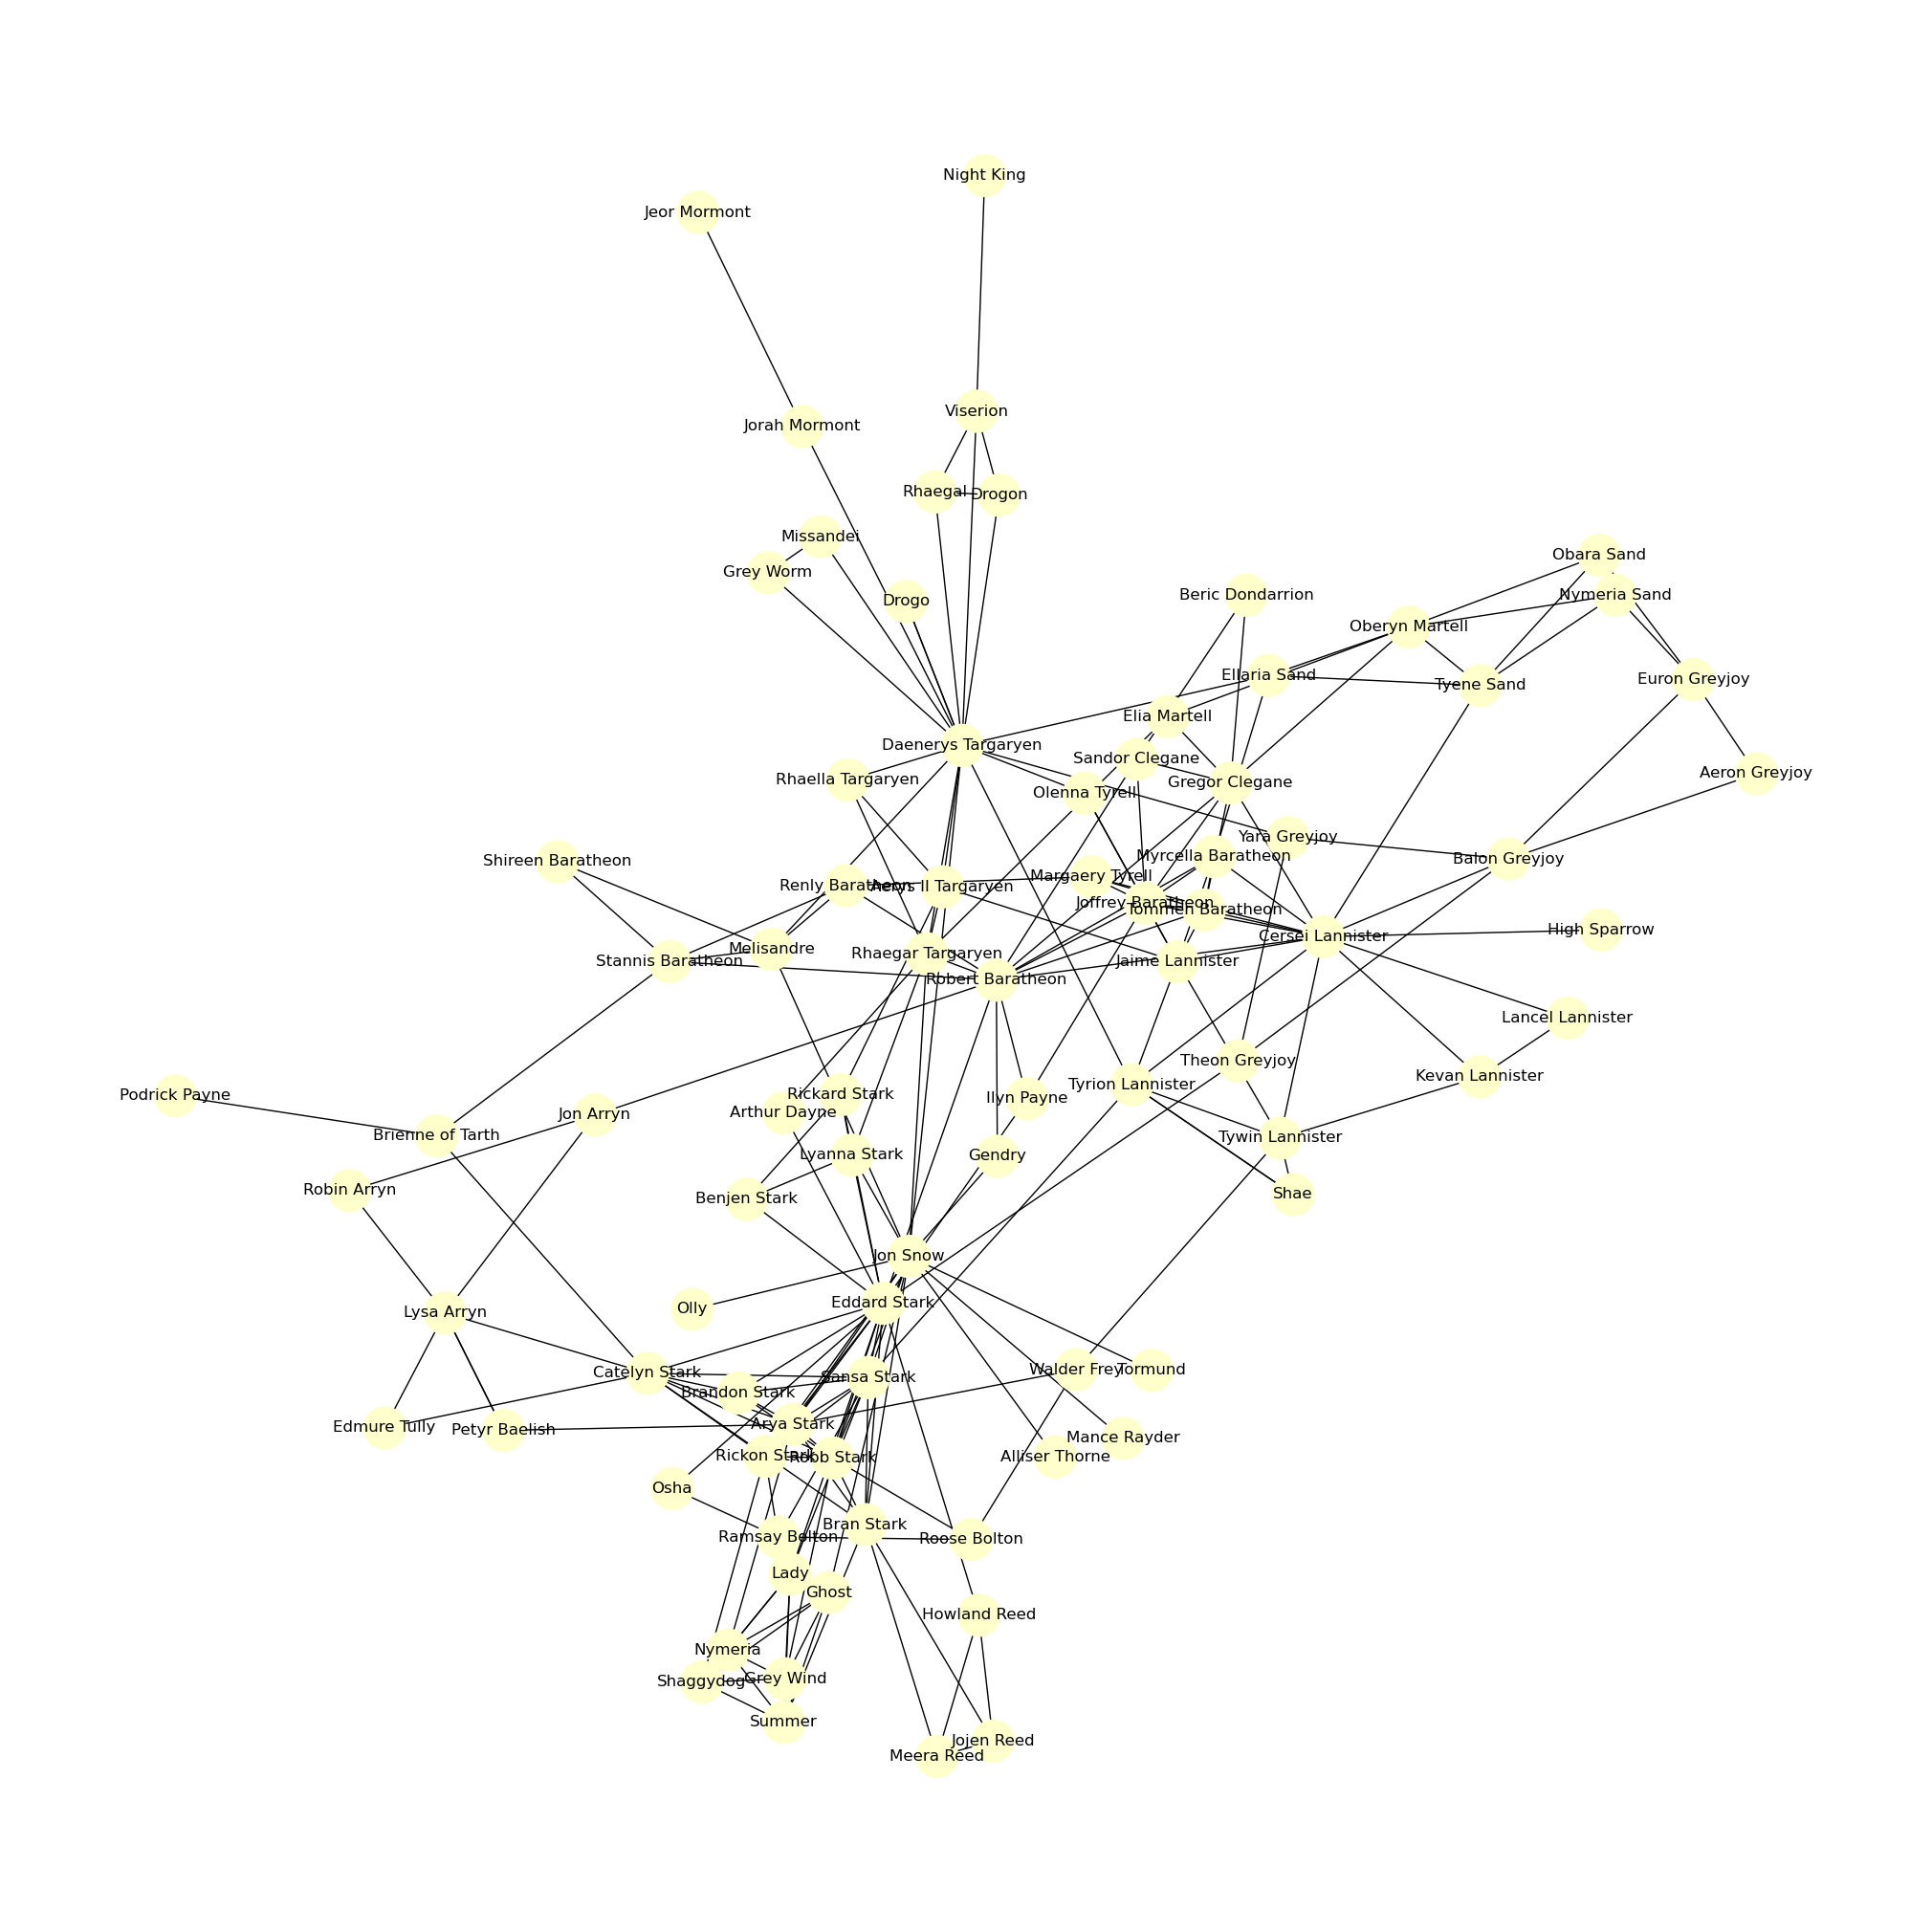

In [4]:
plot_graph(graph)

# 2. K-core decomposition

Now we will perform a k-core decomposition, using the following auxiliary functions.

In [5]:
def get_max_degree(g):
    degree_sequence = [x[1] for x in g.degree()]
    return(max(degree_sequence))


def nodes_with_degree_less_or_equal_than(g, degree):
    nodes = []
    for node in g.nodes():
        if g.degree(node) <= degree:
            nodes.append(node)
    return nodes

The following function computes the K-core decomposition of a graph.

In [6]:
def kcore_decomposition(graph):
    g = graph.copy()
    max_degree = get_max_degree(g)

    node_to_level = {}
    for level in range(1, max_degree + 1):

        while True:
            # Obtain the list of nodes with degree <= level
            nodes_in_level = nodes_with_degree_less_or_equal_than(g, level)

            # Check if this list is empty
            if len(nodes_in_level) == 0:
                break;

            # If the list is not empty, assign the nodes to the
            # corresponding level and remove the node
            for node in nodes_in_level:
                node_to_level[node] = level
                g.remove_node(node)

    return(node_to_level)

Now, we test our function.

In [7]:
node_to_kcore = kcore_decomposition(graph)

for character in ["Jon Snow", "Tyrion Lannister", "Night King"]:
    print("K-core of {:s}: {:d}".format(character, node_to_kcore[character]))

K-core of Jon Snow: 6
K-core of Tyrion Lannister: 3
K-core of Night King: 1


Let's create a subgraph `graphcore` that contains only nodes with k-core greater or equal to 4.

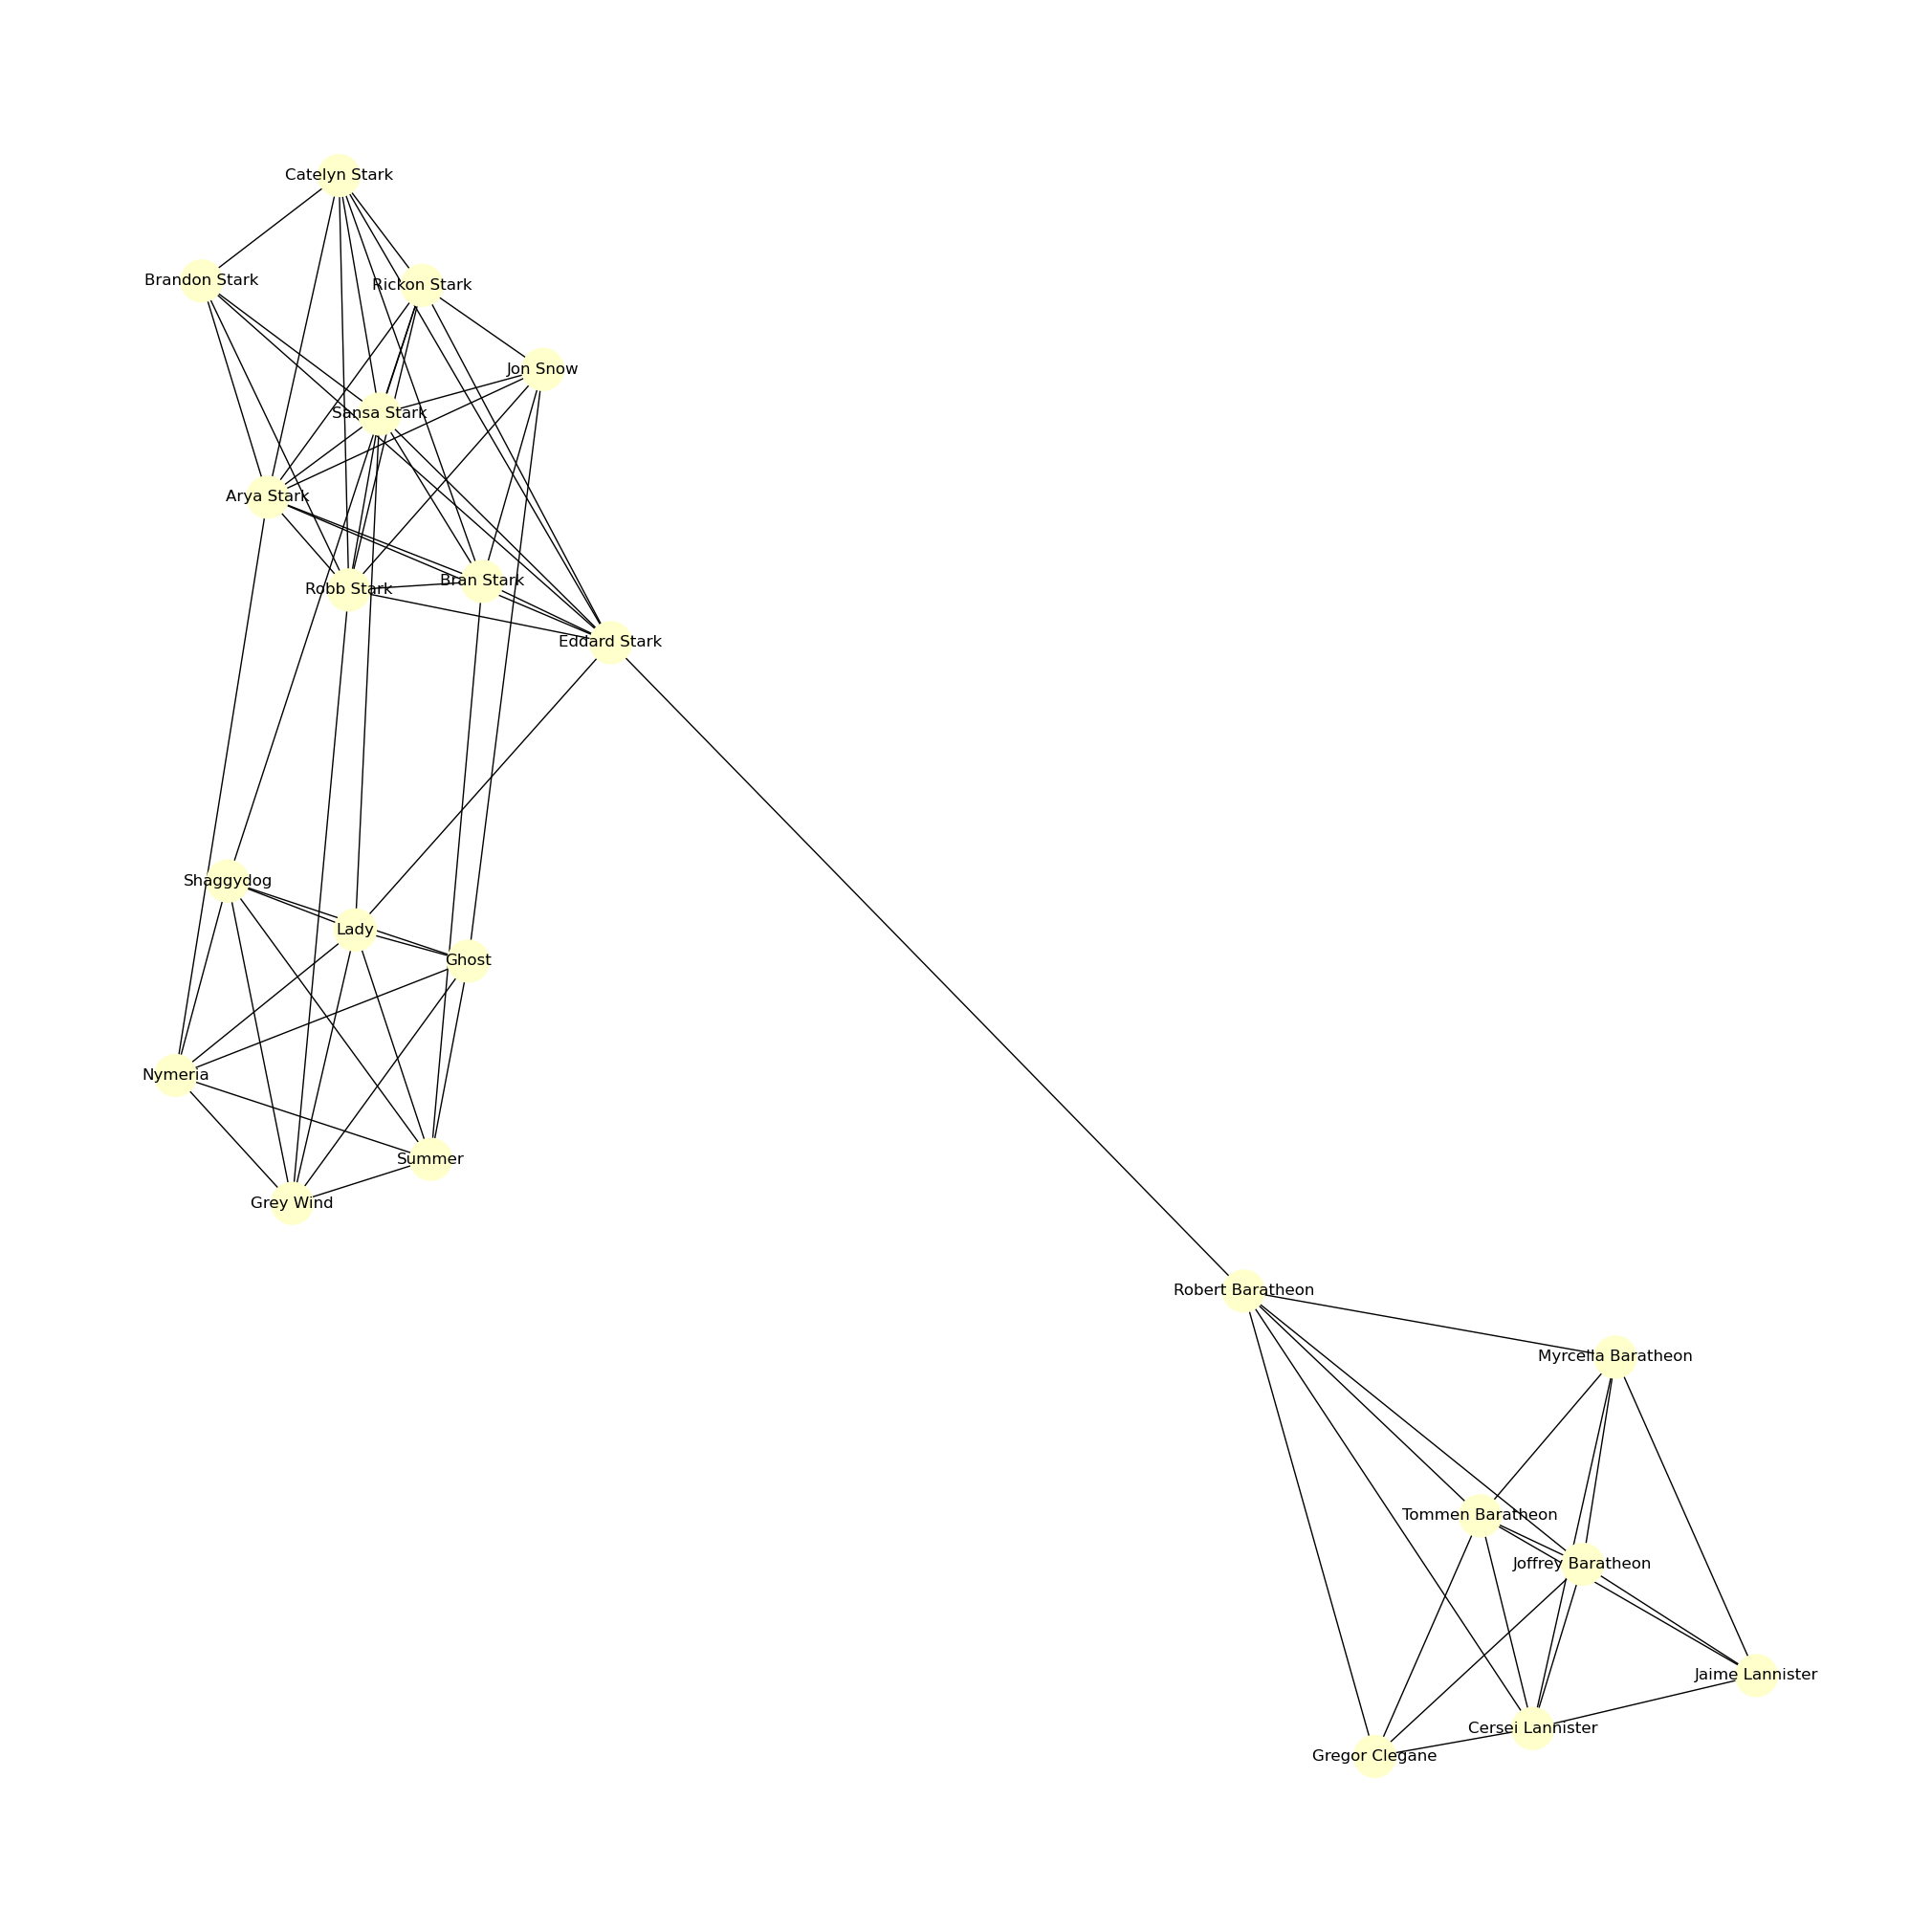

In [8]:
# Apply k-core decomposition to the graph
node_to_level = kcore_decomposition(graph)

# 'Core_nodes' contains nodes with k-core greater or equal to 4
core_nodes = []
for node, level in node_to_level.items():
    if level >= 4:
        core_nodes.append(node)

# Create a subgraph with the nodes in 'core_nodes'
graphcore = graph.subgraph(core_nodes)

# Draw the graph
plot_graph(graphcore)

The graph represents a subset of characters with a k-core greater or equal than 4. In the context of Game of Thrones, the graph depicts characters having strong connections with each other. <br> Furthermore, two communities can be clearly identified from the graph: house Baratheon and house Stark. The characters connecting these two houses are Eduard Stark and Robert Baratheon.

# 3. Modularity of a partition

We will compute the modularity of a partitioning. First, let's draw a small toy graph.

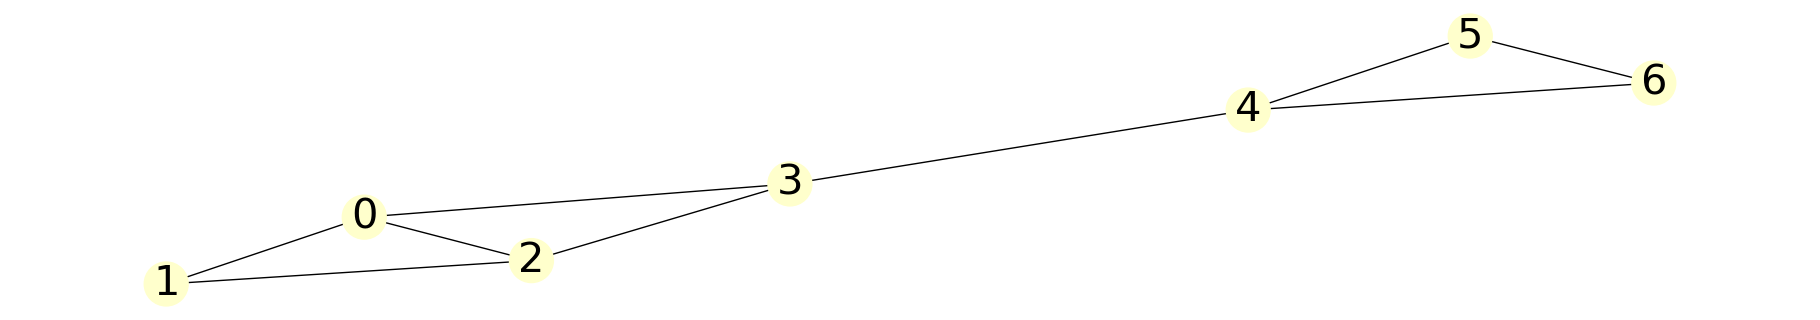

In [9]:
g = nx.Graph()

g.add_edge(0, 1)
g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(3, 0)
g.add_edge(0, 2)
g.add_edge(3, 4)
g.add_edge(4, 5)
g.add_edge(5, 6)
g.add_edge(6, 4)

plot_graph(g, height=3, width=18, font_size=30)

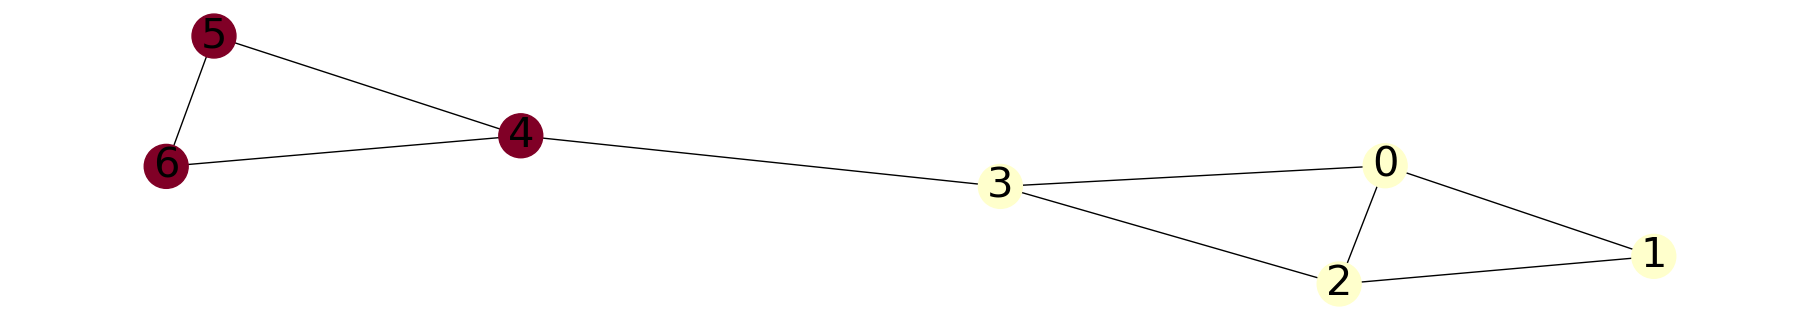

Modularity of partition 1 according to NetworkX: 0.3642


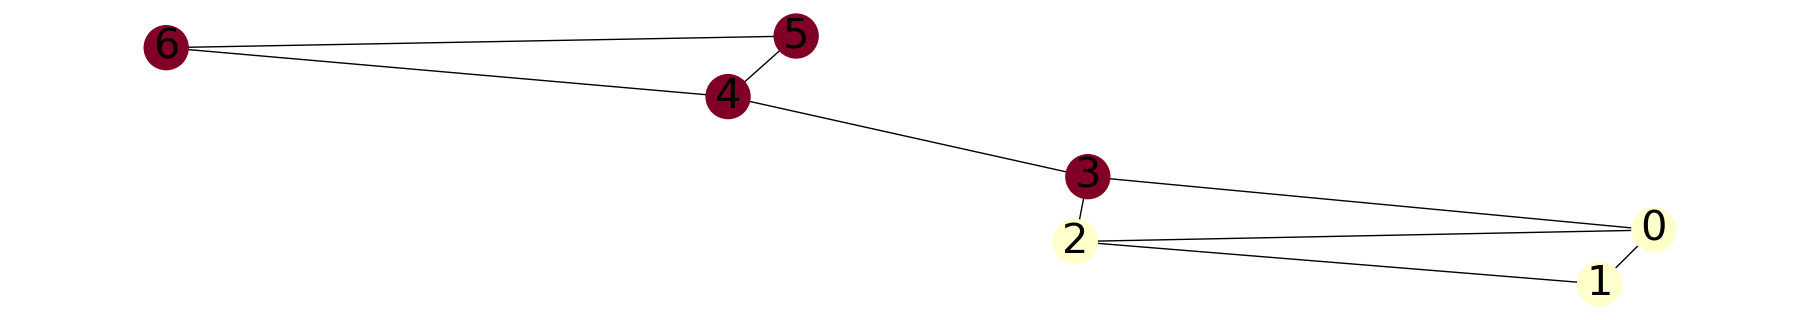

Modularity of partition 2 according to NetworkX: 0.2716


In [10]:
partition1 = [
    {0, 1, 2, 3},
    {4, 5, 6}
]
plot_graph(g, height=3, width=18, font_size=30, partition=partition1)
print("Modularity of partition 1 according to NetworkX: %.4f" % nx.community.quality.modularity(g, partition1))


partition2 = [
    {0, 1, 2},
    {3, 4, 5, 6}
]
plot_graph(g, height=3, width=18, font_size=30, partition=partition2)
print("Modularity of partition 2 according to NetworkX: %.4f" % nx.community.quality.modularity(g, partition2))

Let's create a function `modularity(g, partition)` to compute the modularity of a partition in a graph. To do so, we will first define two functions `Lc(g, C)`-that returns the number of internal links within the community C- and `kc(g, C)`-that returns the sumation of the degree of nodes in C.

In [11]:
def Lc(g, C):
    # Create a subgraph with nodes in g that are in C
    subgraph = g.subgraph(C)
    
    # Count number of edges in the subgraph
    return subgraph.number_of_edges()

In [12]:
def kc(g, C):
    # Create a dictionary with the degrees of all nodes in C and retrieve the degrees
    degrees = dict(g.degree(C)).values()
    
    # Sum degrees
    return sum(degrees)

In [13]:
def modularity(g, partition):
    # Compute the total number of links in the graph
    L = g.number_of_edges()

    # Compute modularity
    Q = 0
    
    for community in partition:
        # Internal links within community C
        Lc_val = Lc(g, community)
        # Sum of degrees of nodes in community C
        kc_val = kc(g, community)
        # Apply formula for contribution to modularity
        Q += Lc_val - (kc_val ** 2) / (4 * L)

    # Normalize dividing by number of edges
    Q /= L

    return Q

And test our code.

In [14]:
print("Modularity of partition 1: mine={:.6f}, networkx={:.6f}".format(
    modularity(g, partition1), nx.community.quality.modularity(g, partition1)))

print("Modularity of partition 2: mine={:.6f}, networkx={:.6f}".format(
    modularity(g, partition2), nx.community.quality.modularity(g, partition2)))


Modularity of partition 1: mine=0.364198, networkx=0.364198
Modularity of partition 2: mine=0.271605, networkx=0.271605


# 4. Girvan-Newman algorithm

## 4.1. Find the edge with the largest betweenness

Now, we write a function to find the edge with the largest betweenness in a graph.

In [15]:
def largest_betweenness_edge(graph):
    # Compute edge betweennes centrality
    # Obtain dictionary where keys are edges and values are edge betweenness
    edge_betweenness = nx.edge_betweenness_centrality(graph)

    # Identify the edge with maximum edge betweenness
    max_betweenness_edge = max(edge_betweenness, key=edge_betweenness.get)

    # Check if key is a triple and return a tuple if so
    if len(max_betweenness_edge) == 3:
        max_betweenness_edge = max_betweenness_edge[:2] # Take first two elements of the tuple

    return max_betweenness_edge

And test our function.

In [16]:
print(largest_betweenness_edge(g))

(3, 4)


## 4.2. Iteratively remove the edge with the largest betweenness

To implement the `girvan_newman` algorithm, we will modify the function `list_connected_components` of NetworkX so that it returns a list and not a generator.

In [17]:
def list_connected_components(g):
    return list(nx.connected_components(g))

def number_connected_components(g):
    return len(list_connected_components(g))

Now, let's implement the `girvan_newman` algorithm.

In [18]:
def girvan_newman(orig):
    # Copy the original graph
    g = orig.copy()

    # All of the nodes in a single partition is the first partition we create
    partition_sequence = [list_connected_components(g)]

    # Compute the current number of connected components
    ncomp = number_connected_components(g)

    # While we have not arrived at a situation where each node is a singleton
    while ncomp < g.number_of_nodes():
        # Find an edge to remove and remove it
        edge_to_remove = largest_betweenness_edge(g)
        g.remove_edges_from([edge_to_remove])

        # Recompute the new number of connected components (ncomp_new)
        ncomp_new = number_connected_components(g)

        # If the number of connected components has increased
        if ncomp_new > ncomp:
            # Add to the partition sequence the list of connected components
            partition_sequence.append(list_connected_components(g))
            # Update the number of connected components
            ncomp = ncomp_new

    return partition_sequence

The following cell runs the Girvan-Newman algorithm and prints the modularity profile.

In [19]:
def run_girvan_newman(g):

    partitions = girvan_newman(g)
    modularity_profile = []    
    for partition in partitions:
        print("Partition %s" % (partition,) )
        m = modularity(g, partition)
        print("Modularity: %.4f" % m)
        modularity_profile.append(m)
        print()  
        
    plt.xlabel("Iteration")
    plt.ylabel("Modularity")
    plt.title("Modularity profile")
    plt.plot(modularity_profile)

Partition [{0, 1, 2, 3, 4, 5, 6}]
Modularity: 0.0000

Partition [{0, 1, 2, 3}, {4, 5, 6}]
Modularity: 0.3642

Partition [{0, 2, 3}, {1}, {4, 5, 6}]
Modularity: 0.2531

Partition [{0}, {1}, {2, 3}, {4, 5, 6}]
Modularity: 0.1420

Partition [{0}, {1}, {2}, {3}, {4, 5, 6}]
Modularity: 0.0864

Partition [{0}, {1}, {2}, {3}, {4}, {5, 6}]
Modularity: -0.0617

Partition [{0}, {1}, {2}, {3}, {4}, {5}, {6}]
Modularity: -0.1481



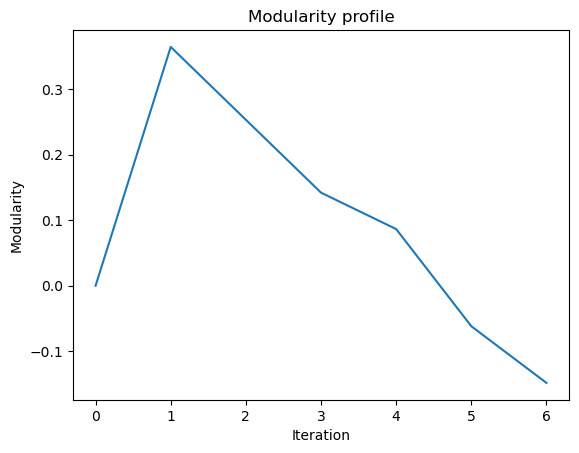

In [20]:
run_girvan_newman(g)

Partition [{'Walder Frey', 'Kevan Lannister', 'Ilyn Payne', 'Tyene Sand', 'Drogo', 'Myrcella Baratheon', 'Sansa Stark', 'Rickon Stark', 'Robert Baratheon', 'Shireen Baratheon', 'Benjen Stark', 'Jaime Lannister', 'Daenerys Targaryen', 'Jojen Reed', 'Tommen Baratheon', 'Euron Greyjoy', 'Brienne of Tarth', 'Lysa Arryn', 'Gregor Clegane', 'Ghost', 'Alliser Thorne', 'Roose Bolton', 'Yara Greyjoy', 'Rhaella Targaryen', 'Catelyn Stark', 'Rhaegar Targaryen', 'Shae', 'Missandei', 'Stannis Baratheon', 'Summer', 'Oberyn Martell', 'Howland Reed', 'Tormund', 'Arya Stark', 'Gendry', 'Bran Stark', 'Elia Martell', 'Renly Baratheon', 'Jorah Mormont', 'Rhaegal', 'Lancel Lannister', 'Tyrion Lannister', 'Beric Dondarrion', 'Robb Stark', 'Tywin Lannister', 'Shaggydog', 'Theon Greyjoy', 'Jon Arryn', 'Lady', 'Petyr Baelish', 'Sandor Clegane', 'Robin Arryn', 'Grey Worm', 'Aerys II Targaryen', 'Podrick Payne', 'Balon Greyjoy', 'Melisandre', 'Brandon Stark', 'Ramsay Bolton', 'Osha', 'Margaery Tyrell', 'Edmure T

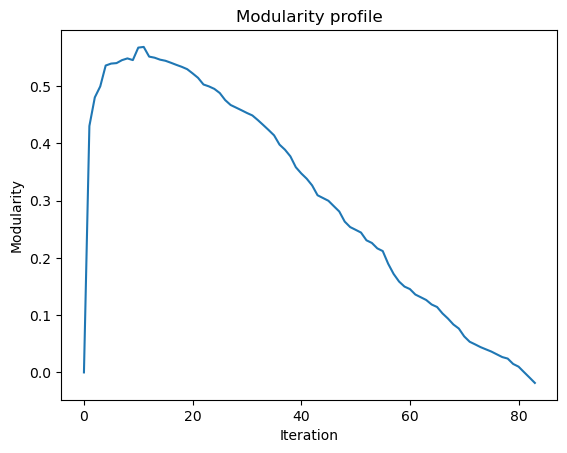

In [21]:
run_girvan_newman(graph)

Partition [{'Catelyn Stark', 'Lady', 'Cersei Lannister', 'Summer', 'Myrcella Baratheon', 'Sansa Stark', 'Arya Stark', 'Rickon Stark', 'Robert Baratheon', 'Joffrey Baratheon', 'Brandon Stark', 'Jon Snow', 'Jaime Lannister', 'Tommen Baratheon', 'Bran Stark', 'Gregor Clegane', 'Eddard Stark', 'Grey Wind', 'Ghost', 'Nymeria', 'Robb Stark', 'Shaggydog'}]
Modularity: 0.0000

Partition [{'Brandon Stark', 'Catelyn Stark', 'Jon Snow', 'Summer', 'Eddard Stark', 'Grey Wind', 'Ghost', 'Sansa Stark', 'Lady', 'Bran Stark', 'Nymeria', 'Arya Stark', 'Robb Stark', 'Rickon Stark', 'Shaggydog'}, {'Jaime Lannister', 'Gregor Clegane', 'Tommen Baratheon', 'Myrcella Baratheon', 'Cersei Lannister', 'Robert Baratheon', 'Joffrey Baratheon'}]
Modularity: 0.3713

Partition [{'Brandon Stark', 'Catelyn Stark', 'Jon Snow', 'Eddard Stark', 'Sansa Stark', 'Bran Stark', 'Arya Stark', 'Robb Stark', 'Rickon Stark'}, {'Summer', 'Ghost', 'Grey Wind', 'Lady', 'Nymeria', 'Shaggydog'}, {'Jaime Lannister', 'Gregor Clegane', 'T

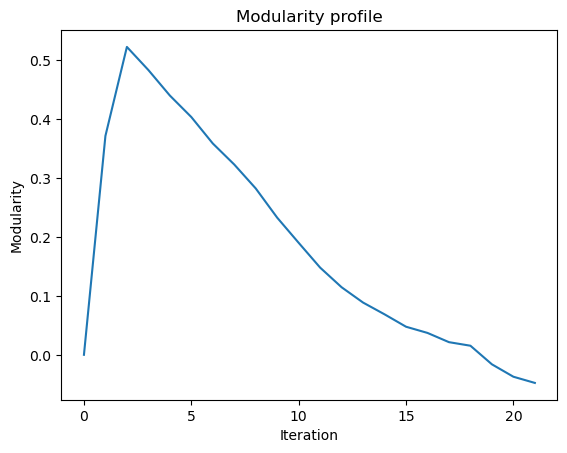

In [22]:
run_girvan_newman(graphcore)

Regarding graph `g`, it can be observed that its modularity increases as the algorithm identifies communities and decreases when the algorithm divides the communities into groups. Since the peak modularity is at iteration 1, the optimal partition should be [{0, 1, 2, 3}, {4, 5, 6}]. In addition, the algorithm stops when it reaches a negatuve modularity of approximately -0.1, which indicates that the observed internal links within communities is lower than expected in a random network. <p> 
On the other hand, `graph` -which represents the whole Game of Thrones network- reaches its peak modularity between the tenth and fifteenth iteration. The largest modularity is 0.5684, and hence the chosen partition should be [{'Tormund'}, {'Brienne of Tarth', 'Podrick Payne'}, {'Grey Worm', 'Jorah Mormont', 'Jeor Mormont', 'Daenerys Targaryen', 'Rhaegal', 'Missandei', 'Drogo', 'Night King', 'Viserion', 'Drogon'}, {'Catelyn Stark', 'Ramsay Bolton', 'Sansa Stark', 'Bran Stark', 'Walder Frey', 'Lyanna Stark', 'Roose Bolton', 'Rickard Stark', 'Gendry', 'Brandon Stark', 'Alliser Thorne', 'Eddard Stark', 'Olly', 'Arthur Dayne', 'Robb Stark', 'Arya Stark', 'Osha', 'Jon Snow', 'Rickon Stark', 'Mance Rayder', 'Benjen Stark'}, {'Tywin Lannister', 'Jaime Lannister', 'Tommen Baratheon', 'Tyrion Lannister', 'Myrcella Baratheon', 'Margaery Tyrell', 'Joffrey Baratheon', 'Robert Baratheon', 'Olenna Tyrell', 'Lancel Lannister', 'Kevan Lannister', 'Shae', 'Beric Dondarrion', 'Gregor Clegane', 'Ilyn Payne', 'High Sparrow', 'Sandor Clegane', 'Cersei Lannister'}, {'Lysa Arryn', 'Robin Arryn', 'Petyr Baelish', 'Edmure Tully', 'Jon Arryn'}, {'Aerys II Targaryen', 'Rhaegar Targaryen', 'Rhaella Targaryen', 'Elia Martell'}, {'Jojen Reed', 'Howland Reed', 'Meera Reed'}, {'Theon Greyjoy', 'Yara Greyjoy', 'Balon Greyjoy', 'Aeron Greyjoy'}, {'Nymeria', 'Ghost', 'Grey Wind', 'Lady', 'Summer', 'Shaggydog'}, {'Renly Baratheon', 'Melisandre', 'Shireen Baratheon', 'Stannis Baratheon'}, {'Tyene Sand', 'Ellaria Sand', 'Nymeria Sand', 'Oberyn Martell', 'Obara Sand', 'Euron Greyjoy'}] <p>
Finally, graph `graphcore` -representing all characters with a k-core greater or equal than 4- depicts the community structure of the strongly connected characters. It reaches the peak modularity at iteration three, with a value for modularity of 0.5222 and optimal partition [{'Nymeria', 'Ghost', 'Grey Wind', 'Lady', 'Summer', 'Shaggydog'}, {'Brandon Stark', 'Eddard Stark', 'Catelyn Stark', 'Robb Stark', 'Arya Stark', 'Jon Snow', 'Sansa Stark', 'Rickon Stark', 'Bran Stark'}, {'Jaime Lannister', 'Tommen Baratheon', 'Myrcella Baratheon', 'Robert Baratheon', 'Joffrey Baratheon', 'Gregor Clegane', 'Cersei Lannister'}]. <p>
Comparing these two last modularity profiles, it can be seen that the 4-core subgraph reaches its peak modularity before the complete graph. This can be explained becuse the 4-core subgraph contains nodes that are already tightly connected, which can result in a quicker convergence to high modularity. However, it should be noted that the 4-core subgraph has a small size compared to the complete graph, which could also explain this difference in convergence.

The following function `run_girvan_newman_modularity` runs Girvan-Newman and returns the partition with the largest modularity.

In [23]:
def run_girvan_newman_modularity(g):
    # Get a list of partitions
    partitions = girvan_newman(g)
    modularity_profile = [] # Empty list to store modularity values of partitions
    
    # Go through each partition
    for i, partition in enumerate(partitions):
        # Compute modularity
        m = modularity(g, partition)
        # Add modularity to the list
        modularity_profile.append(m)
    
    # Find the index of the partition with maximum modularity within the list modularity profile
    max_modularity_index = modularity_profile.index(max(modularity_profile))
    
    # Return partition with largest modularity
    return partitions[max_modularity_index]

The following cell runs this over the entire graph.

In [24]:
def run_and_plot(name, g):
    partition = run_girvan_newman_modularity(g)
    print("The best partition of {:s} has modularity {:.4f} and {:d} communities".format(
        name, modularity(g, partition), len(partition)))
    plot_graph(g, partition=partition)    

The best partition of the entire graph has modularity 0.5684 and 12 communities


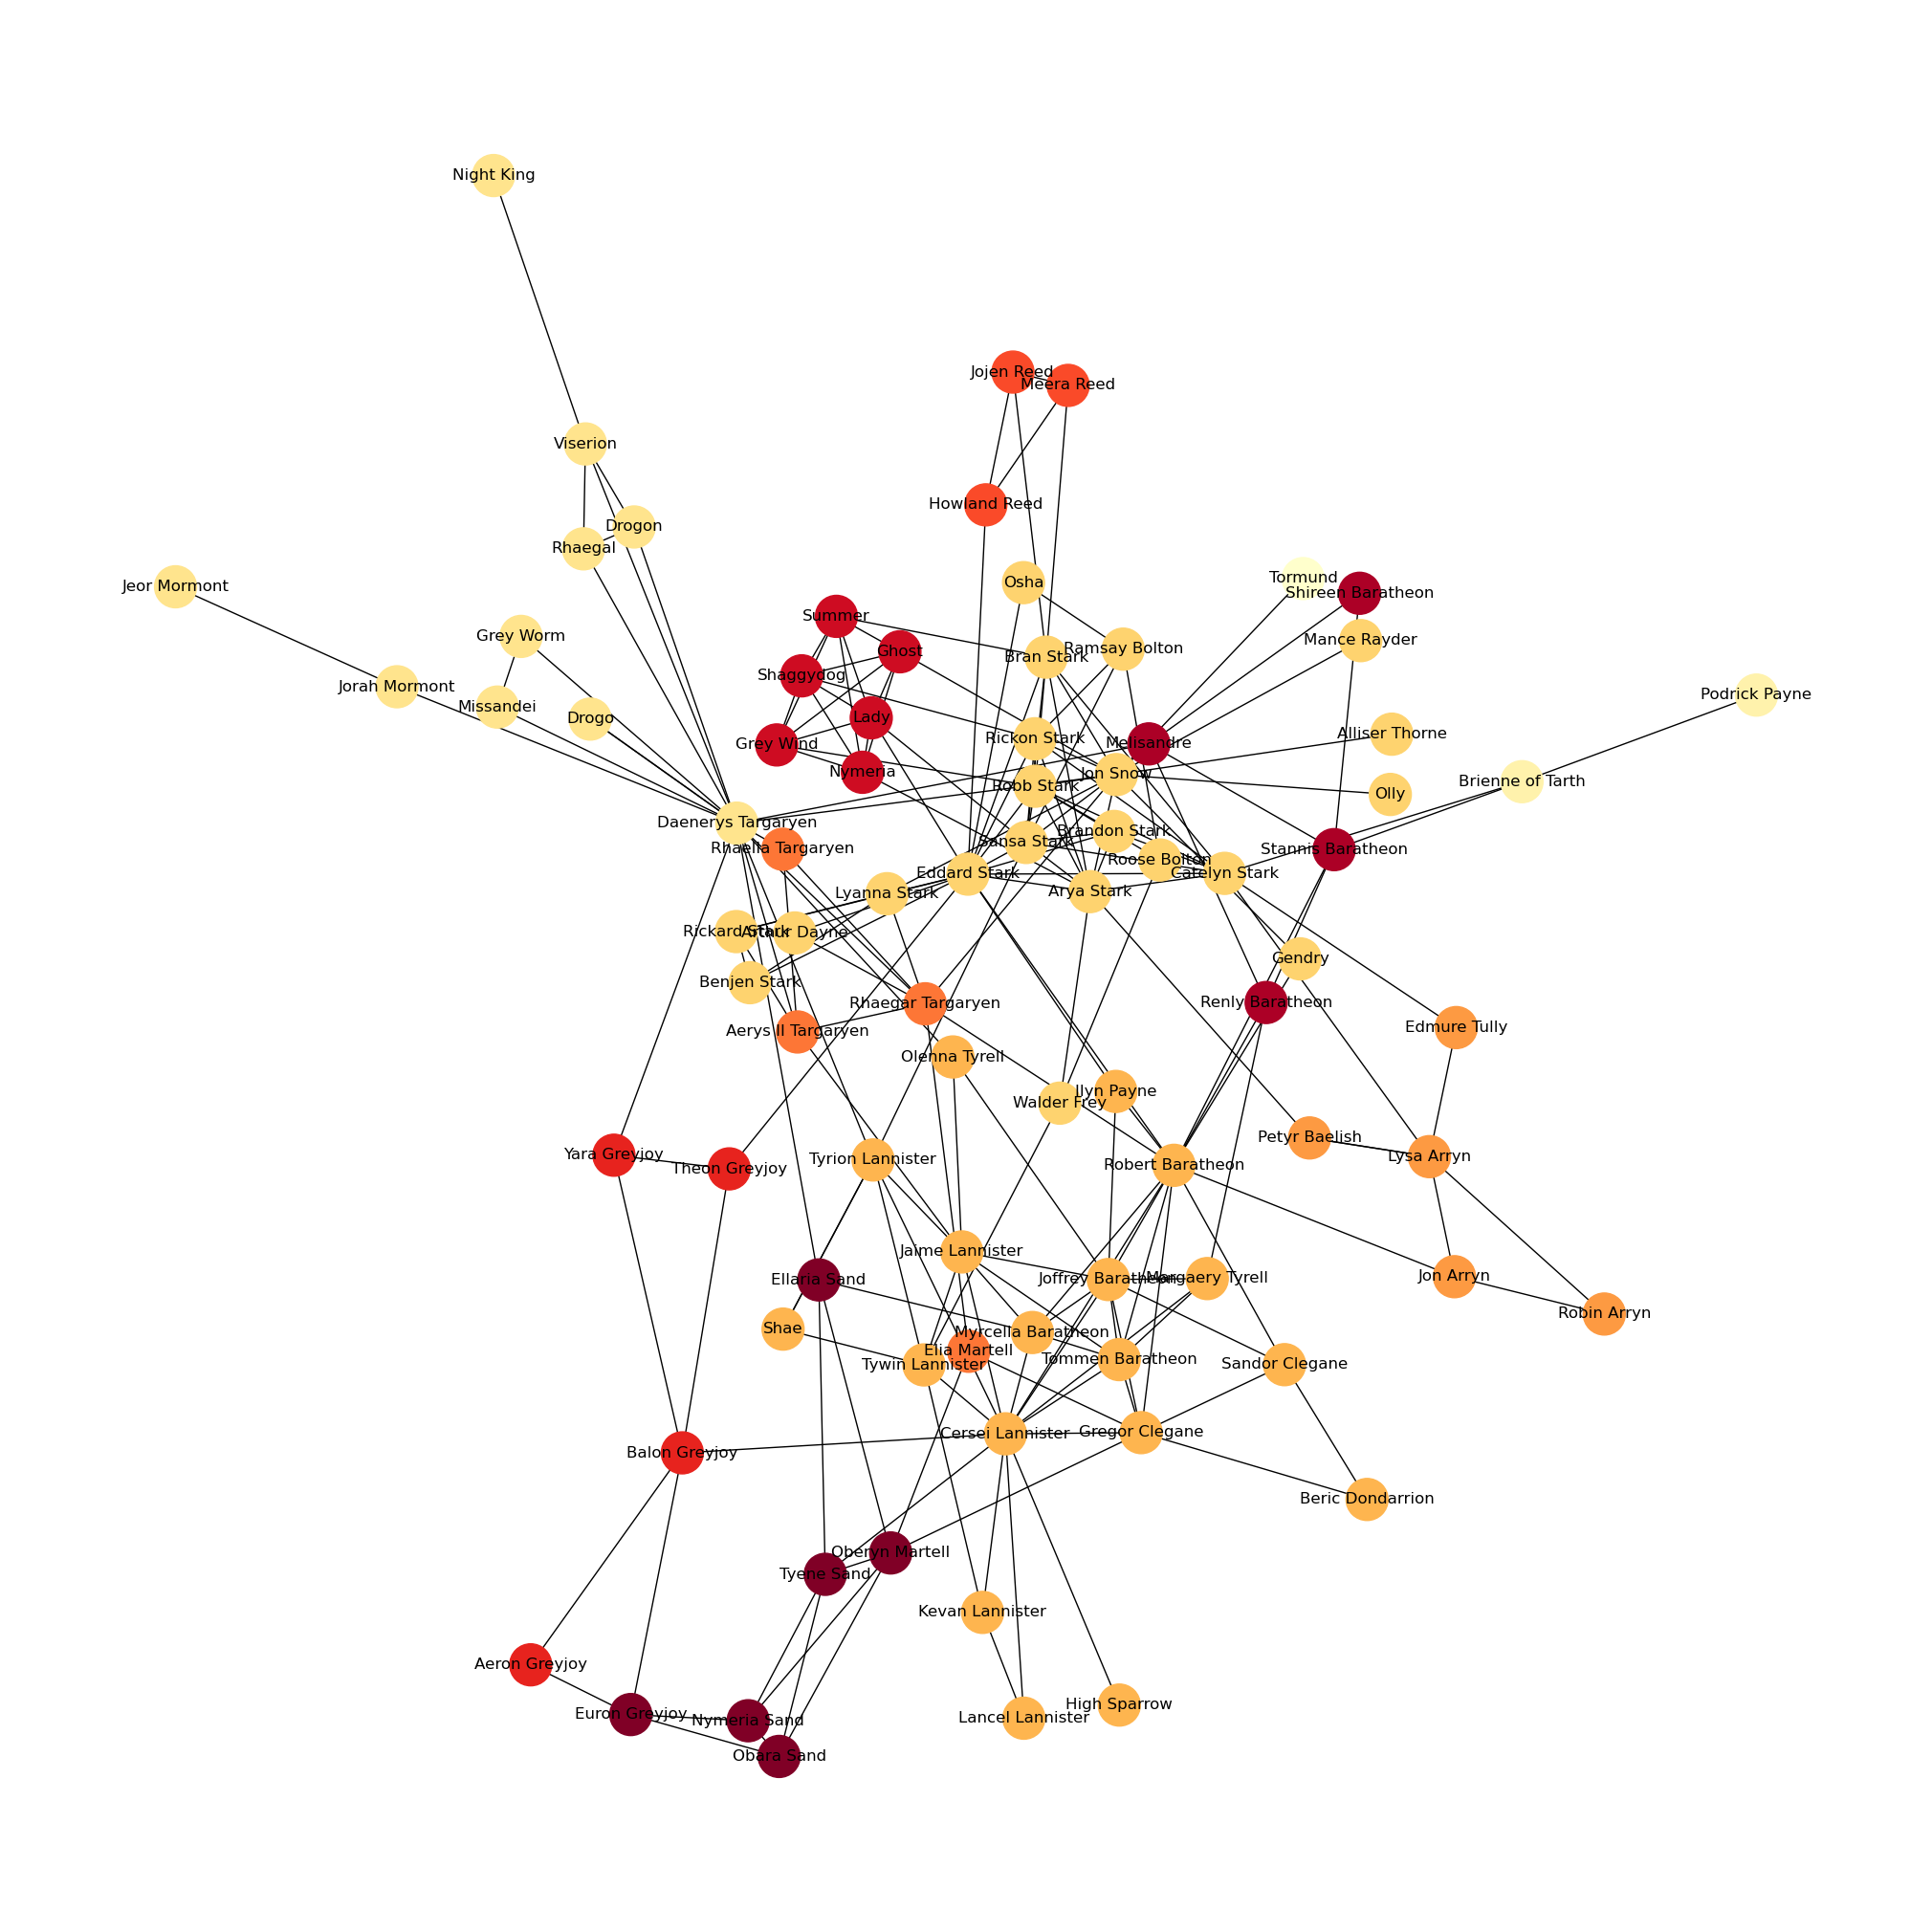

In [25]:
run_and_plot("the entire graph", graph)

The best partition of the core of the graph has modularity 0.5222 and 3 communities


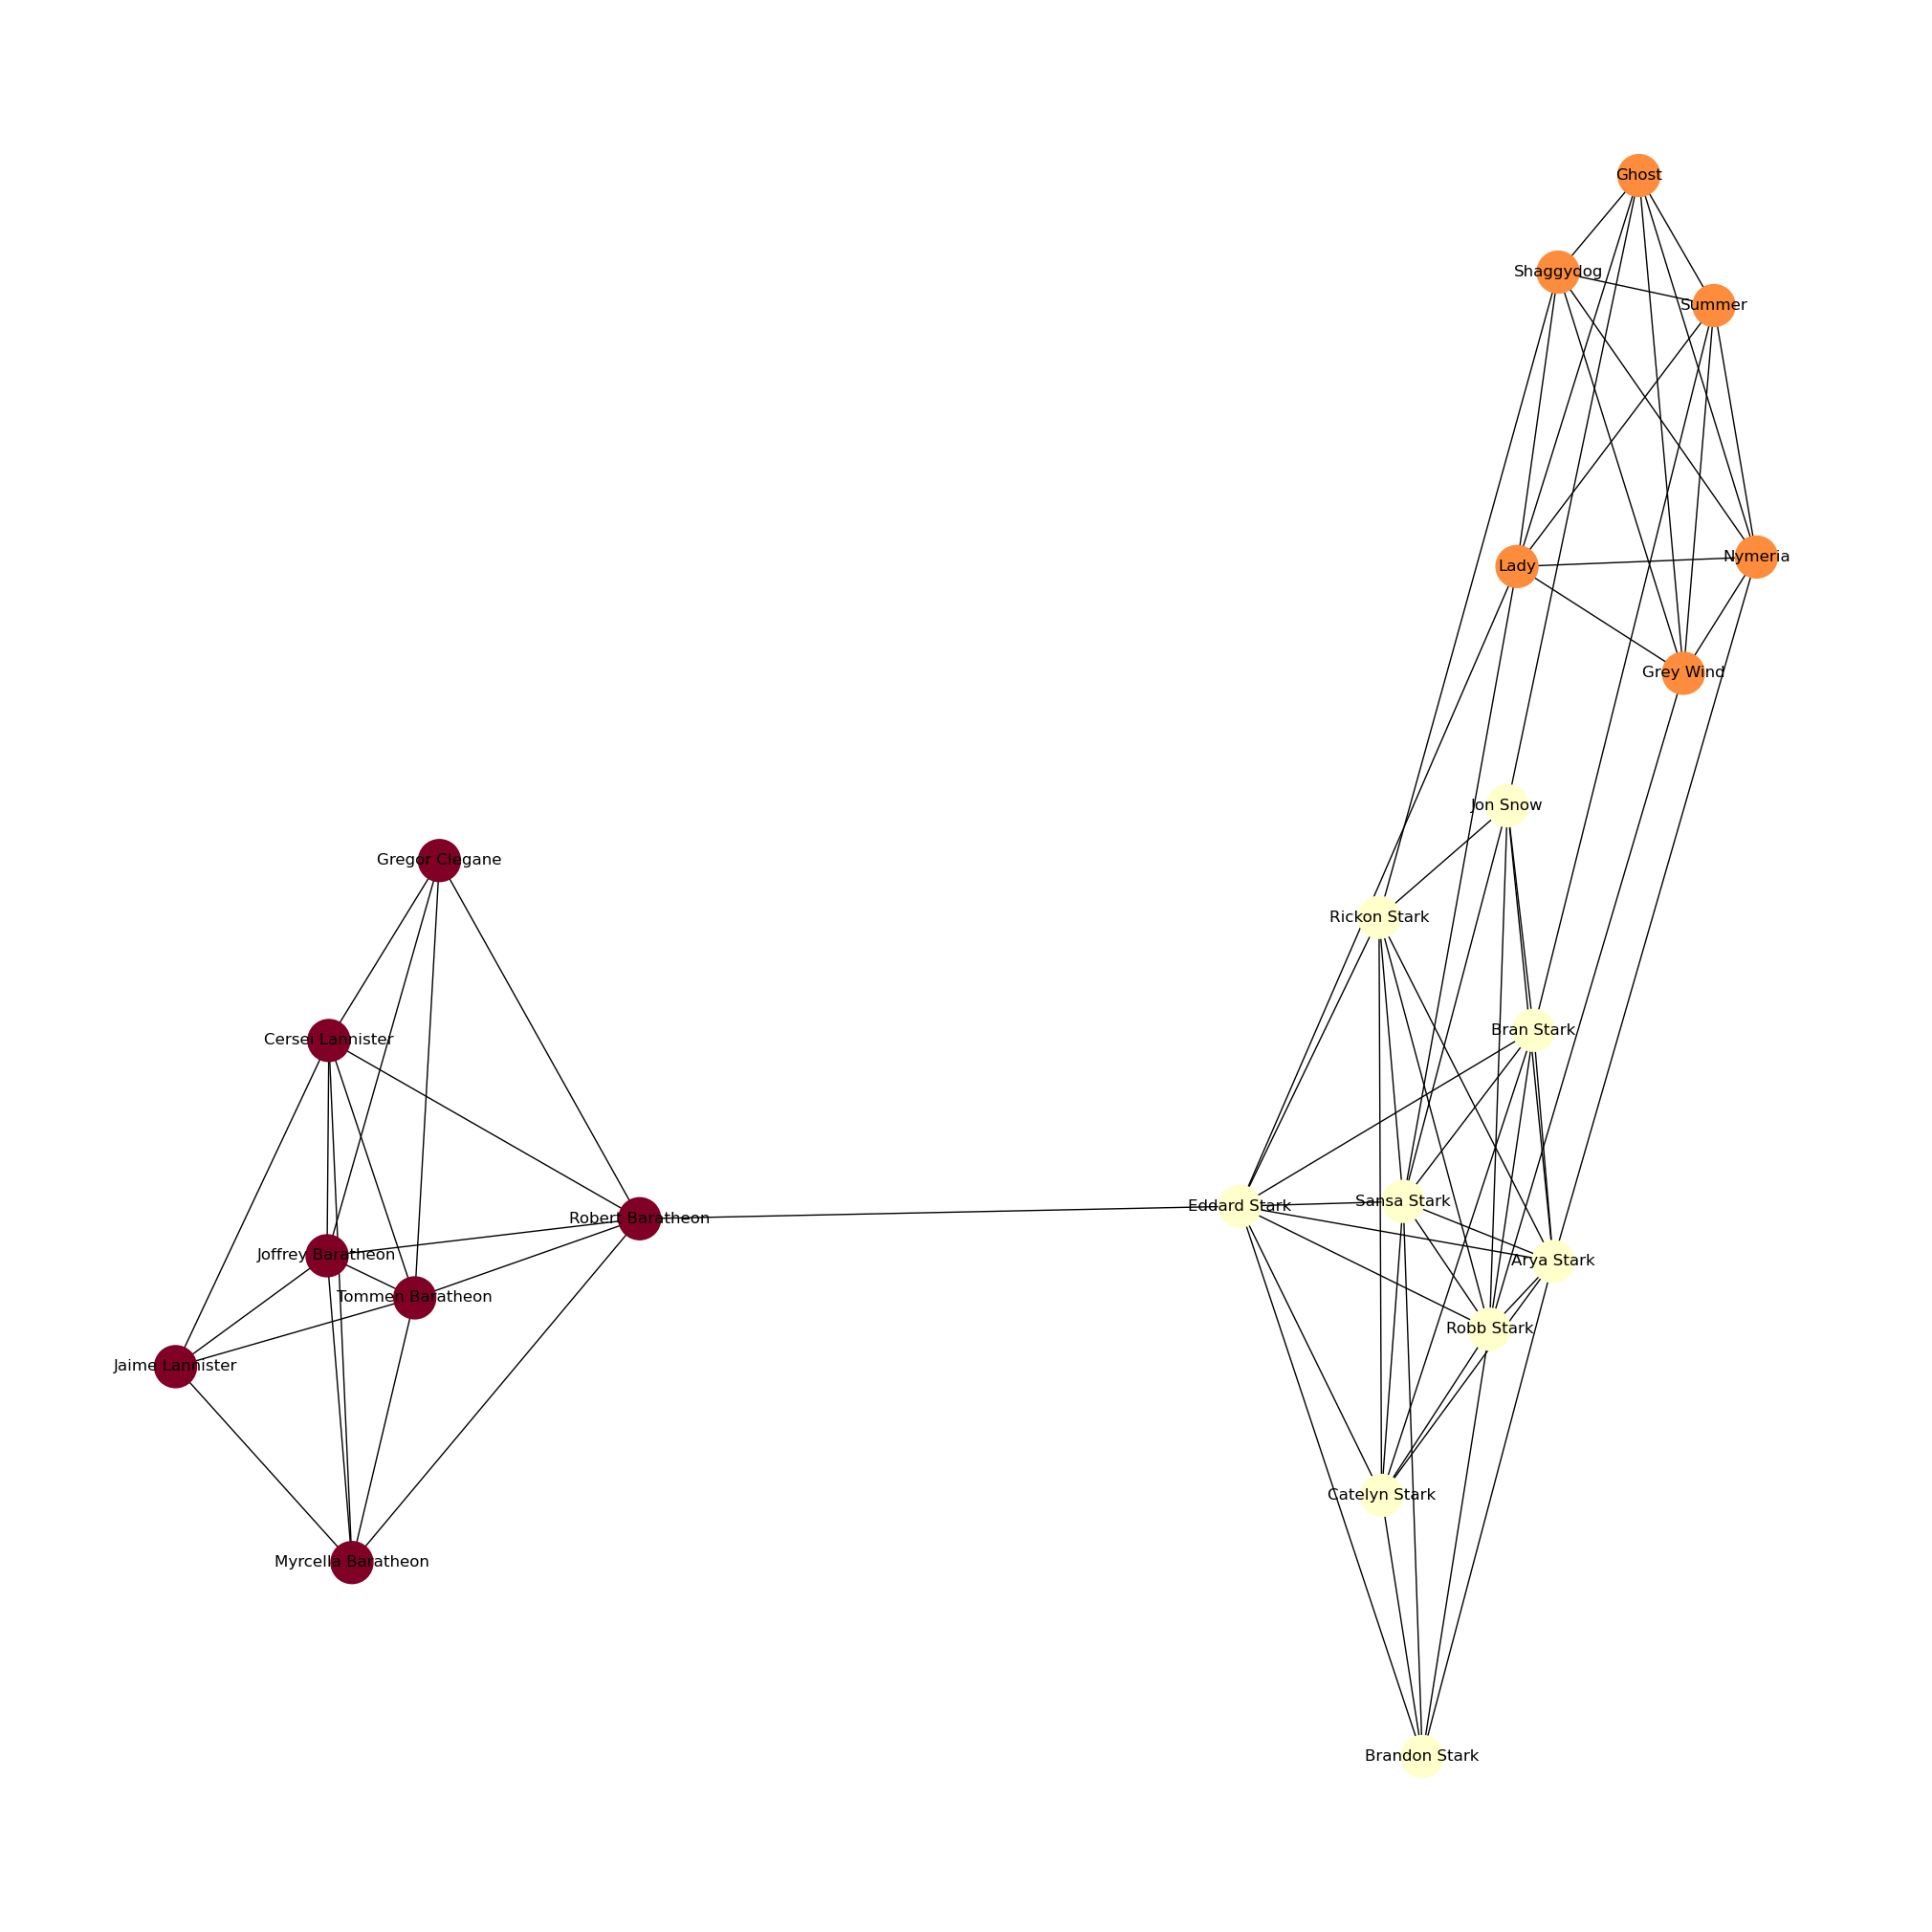

In [26]:
run_and_plot("the core of the graph", graphcore)

On the one hand, characters that have strong connections are grouped into the same community in both partitionings. In particular, the 4-core partitioning depicts the connection between house Stark and house Baratheon, that is indeed strong since, in the series, Eddard Stark and Robert Baratheon were fostered together and Robert admitted he thought of Ned as his brother. The 4-core partitioning also shows the relationship between house Stark and their direwolves: Ghost, Shaggydog, Grey Wind, Lady, Nymeria, and Summer. <p>
    On the other hand, the partitioning of the entire graph groups house Stark and other characters outside this house -e.g. Olly, Mance Rayder, Osha, Walder Frey, Roose Bolton, Ramsay Bolton- into the same community, whereas the partitioning of the 4-core graph groups only characters whose surname is Stark into one community -except for Jon Snow-. Similarly, the partitioning of the entire graph includes more characters in the Baratheon-Lannister-Clegane community than the partitioning of the 4-core graph. For instance, in the entire graph partitioning, High  Sparrow, Olenna Tyrell, and Beric Dondarrion are in the same community as the characters of the 4-core graph Baratheon-Lannister-Clegane community.<p>
    In a nutshell, some characters that are part of the same community in the entire graph partitioning are divided into more tightly-connected communities in the 4-core partitioning.

<p>
    Finally, let's implement a label propagation algorithm to find communities. The algorithm will receive as input the desired number of communities and a target number of iterations. It will first randomly assign each node to one of the communities; then, for the target number of iterations, it will move every node to the community to which the majority of its neighbors belong.

In [27]:
def label_propagation(graph, num_communities, num_iterations):
    # Assign randomly each node to a community
    for node in graph.nodes():
        # Assign community index from 0 to num_communities - 1
        graph.nodes[node]['community'] = random.randint(0, num_communities - 1)
        
    for iterations in range(num_iterations):
        # Create dictionary to store community labels
        next_labels = {}
        
        # Update node label according to majority label of neighbors
        for node in graph.nodes():
            # Create list with community labels for each neighbor
            neighbor_communities = []
            for neighbor in graph.neighbors(node):
                neighbor_community = graph.nodes[neighbor]['community']
                neighbor_communities.append(neighbor_community)
                
            if neighbor_communities: # List is not empty
                # Find most common community among neighbors
                # Convert list to set without duplicates
                unique_neighbor_communities = set(neighbor_communities)
                # Initialize to store most commmon community and count
                most_common_community = None
                max_community_count = 0
                
                for community in unique_neighbor_communities:
                    # Count how many times community appears
                    community_count = neighbor_communities.count(community)
                    if community_count > max_community_count:
                        # Update
                        most_common_community = community
                        max_community_count = community_count
                # Assign to node the community to which the majority of neighbors belong
                next_labels[node]  = most_common_community
            else: # No neighbors, list is empty, keep the label
                next_labels[node] = graph.nodes[node]['community']
                
        # Update community labels for next iteration
        for node, community in next_labels.items():
            graph.nodes[node]['community'] = community
                
    # Return community assignment
    final_communities = []
    # Loop through community index and create sets
    for i in range(num_communities):
        community_set = set()
        final_communities.append(community_set)
        
    for node in graph.nodes():
        community_label = graph.nodes[node]['community'] # Retrieve community label
        # Add node to the set of its community label
        final_communities[community_label].add(node)
        
    return final_communities # List of sets, each set contains nodes from same community

The following cell performs a simple test with our graph.

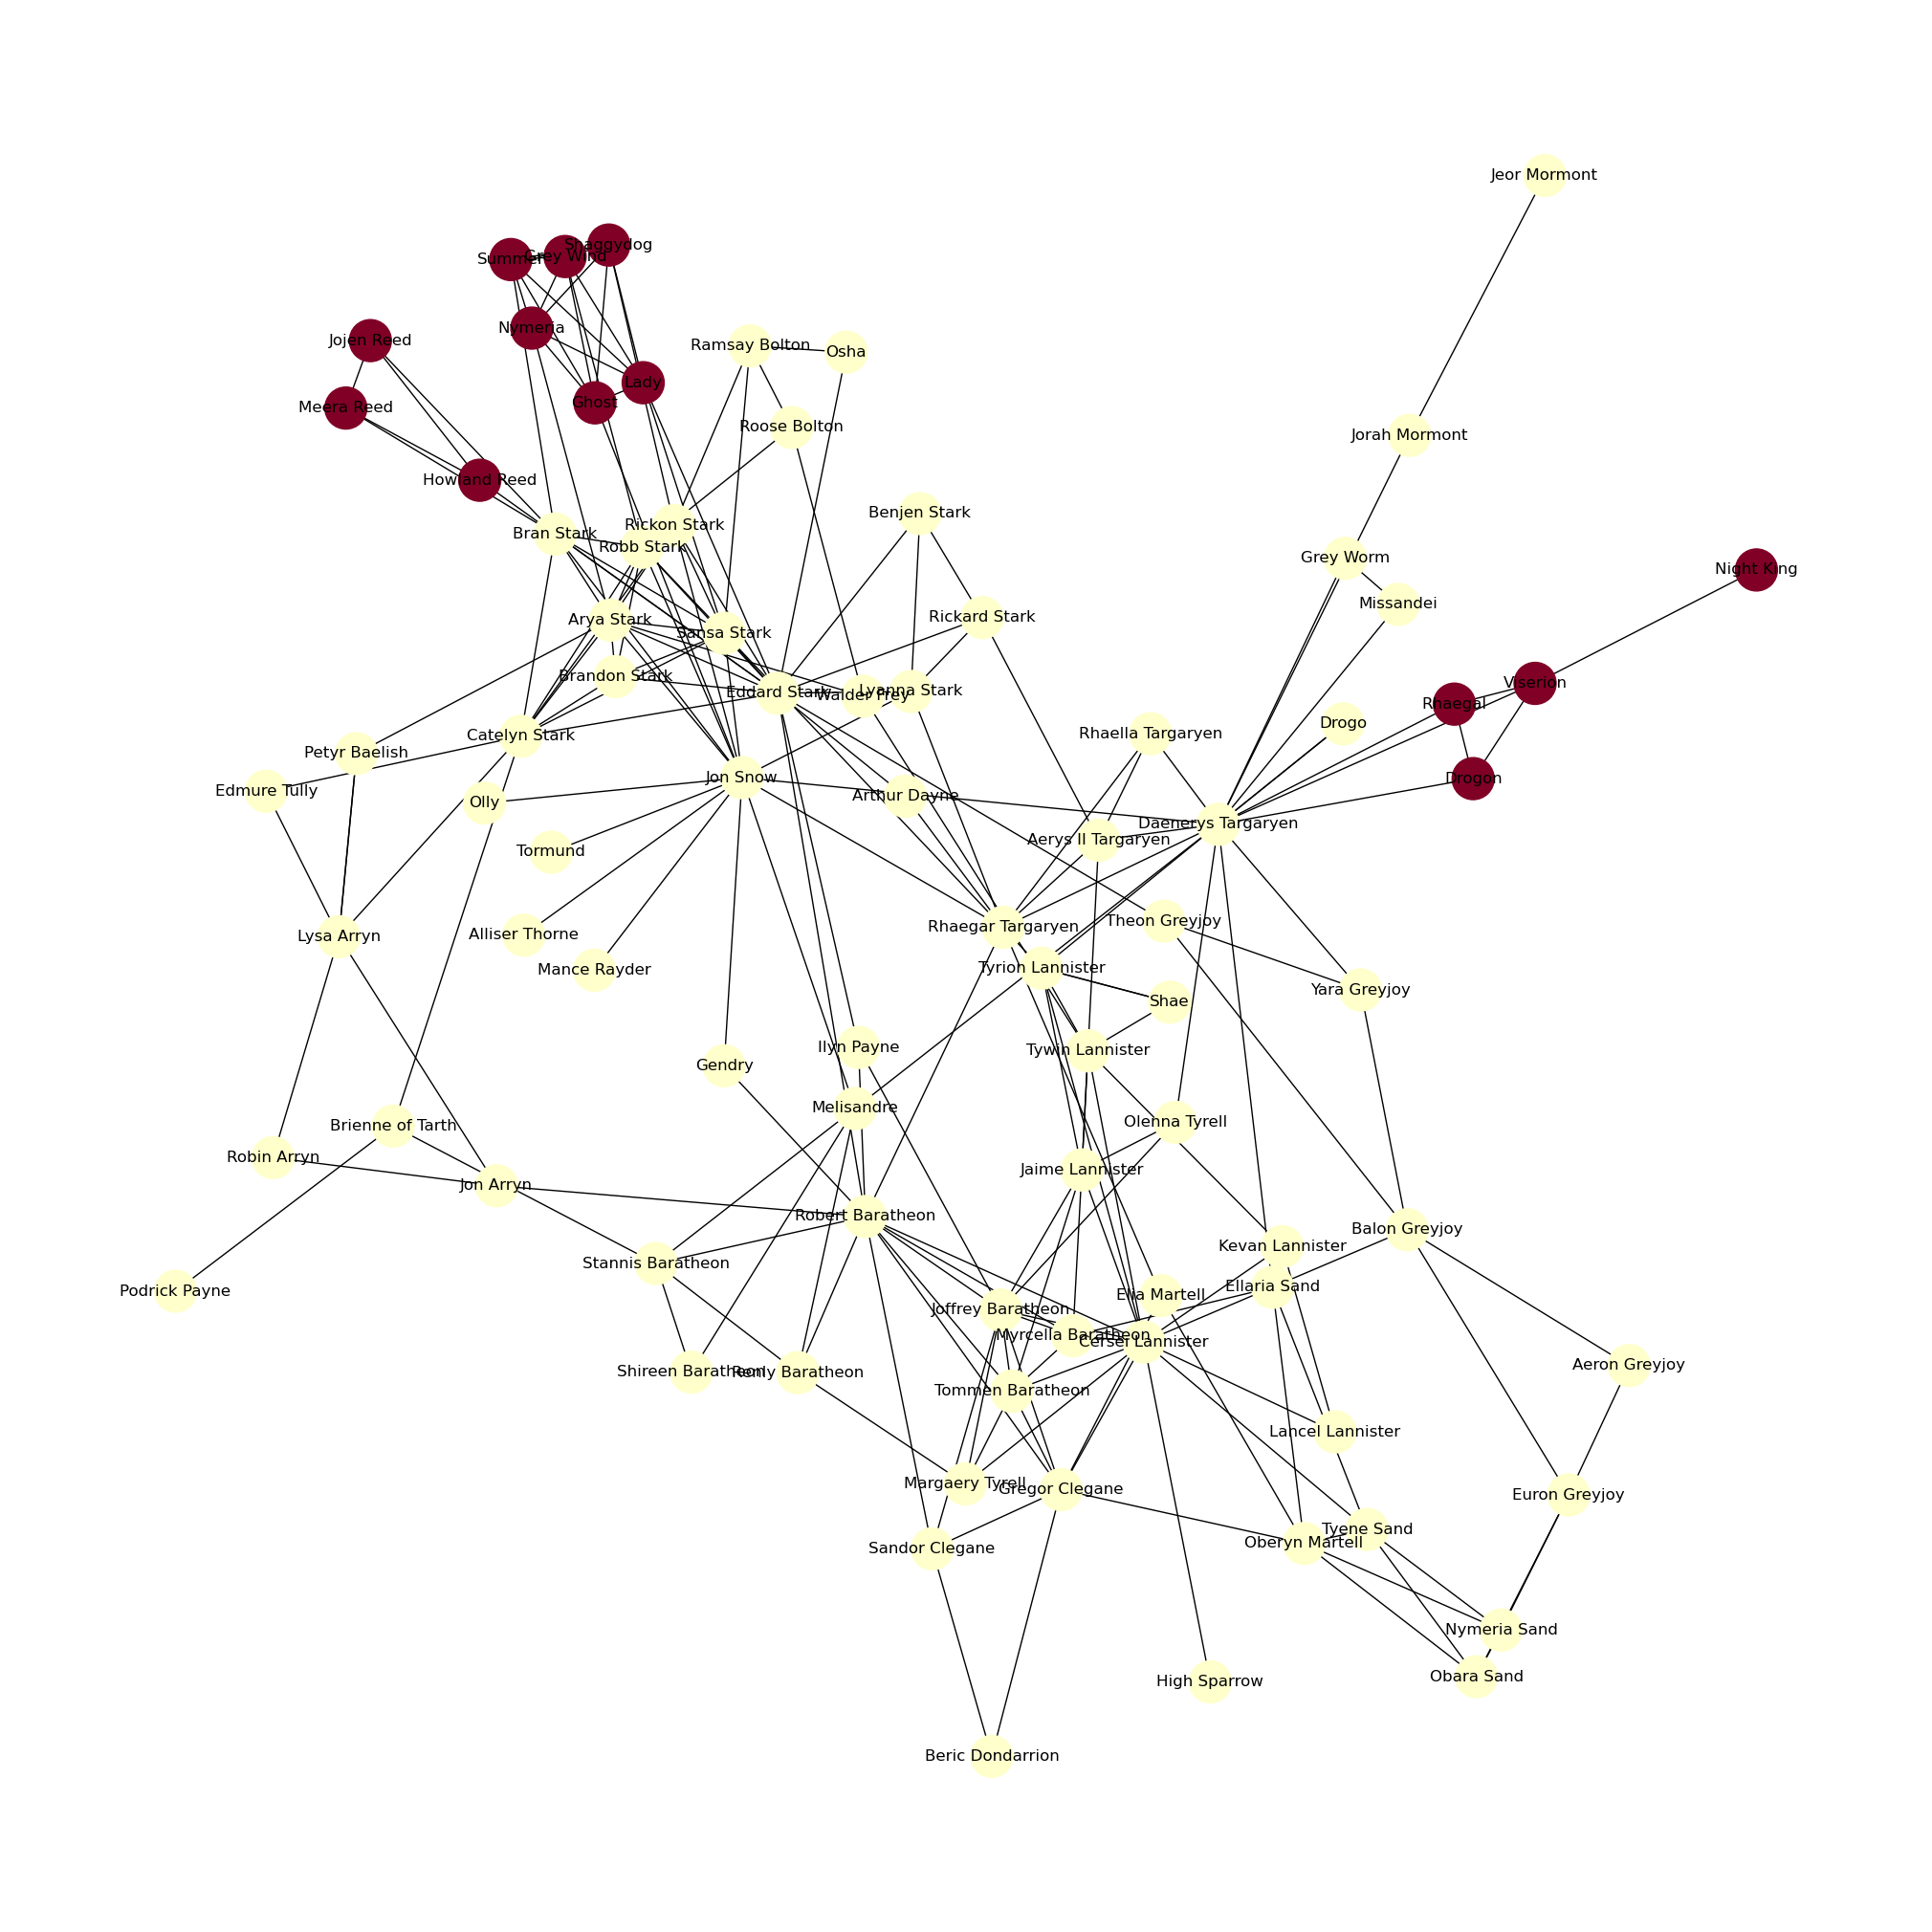

In [28]:
num_communities = 2
num_iterations = 500
final_communities = label_propagation(graph, num_communities, num_iterations)

# Plot graph with colors
plot_graph(graph, partition=final_communities)

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>